# sprint09 DNN

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import math

pd.set_option('display.max_columns', 250)
np.set_printoptions(threshold=np.inf)
import tensorflow as tf

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
### X_test y_testは使用しない？　###
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [4]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
# print(y_train.shape) # (60000,)
# print(y_train_one_hot.shape) # (60000, 10)
# print(y_train_one_hot.dtype) # float64

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

In [5]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [6]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def WI(self, n_nodes1, n_nodes2):
        WI = np.random.randn(n_nodes1, n_nodes2) * self.sigma
        return WI
    def BI(self, n_nodes2):
        BI = np.random.randn(n_nodes2) * self.sigma
        return BI

## 【問題1】全結合層のクラス化  
全結合層のクラス化を行なってください。

In [7]:
class FC:

    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        self.initializer = initializer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2        
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = self.initializer.WI(self.n_nodes1,self.n_nodes2)
        self.B = self.initializer.BI(self.n_nodes2)

    def forward(self, Z):
        self.Z = Z.copy()  ### copyは不要かもしれない。
        A = np.dot(self.Z, self.W)+ self.B
        return A
  
    def backward(self, dA):
        self.dB = dA
        self.dW = np.dot(self.Z.T, dA)
        dZ = np.dot(dA, self.W.T)
        
        self = self.optimizer.update(self) 
        
        return dZ

## 【問題2】初期化方法のクラス化  

初期化を行うコードをクラス化してください。

##  【問題３】最適化手法のクラス化

In [8]:
class SGD:

    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        layer.W = layer.W - self.lr * layer.dW
        layer.B = layer.B - self.lr * layer.dB.mean(axis = 0) 


## 【問題４】　活性化関数のクラス化

In [34]:
class Tanh:
    def __init__(self):
        self.out = None
    def forward(self,x):
#          out = 1/(1 + np.exp(-x))
        out = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
        self.out = out
        return out
    def backward(self,dout):
        dx = dout * (1 - self.out**2) ### 確認。out?
#         dx = dout * (1.0 - self.out) * self.out
        return dx

In [15]:
class Softmax:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    def forward(self,x):
        self.y = np.exp(x)/ (np.sum(np.exp(x),axis=1).reshape(-1,1))
        return self.y
    def backward(self,t):
        self.t = t
        delta_sf = self.y -self.t
#       self.loss = self.cross_entropy_error(self.y, self.t)
        return delta_sf
    def cross_entropy_error(self,y,t):
        self.t = t
        c_entropy = -1/len(self.t)*(np.sum(self.t*np.log(self.y))) ### ｔは1hot_encoder
        return c_entropy

## 【問題５】ＲｅＬＵクラスの作成

In [10]:
class ReLU:
    def __init__(self):
        self.mask = None
    def forward(self,x):
        self.mask = (x <= 0)
        out = x.copy()  ### 念のためcopy() 
        out[self.mask] = 0
        return out
    def backward(self,dout):
        dout[self.mask] = 0
        dx = dout * 1.0
        return dx

## 【問題６】　重みの初期値（Xavierの初期値、Heの初期値）

In [11]:
class Xavier_Initializer:
    def __init__(self,xavier):
        self.xavier = None
    def WI(self, n_nodes1, n_nodes2):
        self.xavier = 1/math.sqrt(n_nodes1)
        WI = np.random.randn(n_nodes1, n_nodes2) * self.xavier
        return WI
    def BI(self, n_nodes2):
        BI = np.random.randn(n_nodes2) * self.xavier
        return BI

In [12]:
class He_Initializer:
    def __init__(self,He):
        self.He = None
    def WI(self, n_nodes1, n_nodes2):
        self.He = math.sqrt(2/n_nodes1)
        WI = np.random.randn(n_nodes1, n_nodes2) * self.He
        return WI
    def BI(self, n_nodes2):
        BI = np.random.randn(n_nodes2) * self.He
        return BI

## 【問題７】　最適化手法（AdaGrad）

In [13]:
class AbaGrad:

    def __init__(self, lr):
        self.lr = lr
        self.grad_w = 0
        self.grad_b = 0

    def update(self, layer):
        self.grad_w = self.grad_w + layer.dW *layer.dW     
        layer.W = layer.W - self.lr * 1/np.sqrt(self.grad_w+0.0000001)*layer.dW
        
        self.grad_b = self.grad_b + (np.mean(layer.dB,axis=0))*(np.mean(layer.dB,axis=0))
        layer.B = layer.B - self.lr * 1/np.sqrt(self.grad_b+0.0000001)*layer.dB.mean(axis = 0) 
        return layer
        
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """

Adagradのコーディングはこれで正しいでしょうか？  
・diverにはイタレーションごとに更新するかのような記載がありますが、ミニバッチごとに更新されるようにしました。  
・diverには平均をとるための「Ｅ」の記号がついてますが、行列演算のためのシェイプを合わせるようにしたので、grad_w = grad_w + dw*dwとしました。  
・更新の際には、grad_wとgrad_bをインスタンス変数として値を保持させることから、ScratchDeepNeuralNetrowkClassifierのfit関数にて、活性化関数ごとにインスタンスを作成しました。  
・初回呼び出し時でのzerodivisionエラーを避けるため、np.sqrt内で0.0000001を加算しました。

## 【問題8】クラスの完成  
## 【問題9】学習と推定

In [14]:
class ScratchDeepNeuralNetrowkClassifier:
    def __init__(self, verbose = True, iter_num=1, lr=0.002, sigma=0.02):
        self.verbose = verbose
        self.iter_num = iter_num
        self.lr = lr
        self.sigma = sigma

    def fit(self,X,y):

        self.n_features = X.shape[1]
        self.n_nodes1 = 400
        self.n_nodes2 = 200
        self.n_output = 10
        optimizer = SGD(self.lr)

        get_mini_batch = GetMiniBatch(X, y)

        self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = Tanh()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = Tanh()
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = Softmax()

        for i in range(self.iter_num):
             for mini_X_train, mini_y_train in get_mini_batch:

                ### forward
                self.A1 = self.FC1.forward(mini_X_train)
                self.Z1 = self.activation1.forward(self.A1)
                self.A2 = self.FC2.forward(self.Z1)
                self.Z2 = self.activation2.forward(self.A2)
                self.A3 = self.FC3.forward(self.Z2)
                self.Z3 = self.activation3.forward(self.A3)

                ### backward
                self.delta1 = self.activation3.backward(mini_y_train)
                self.dZ2 = self.FC3.backward(self.delta1)
                self.delta2 = self.activation2.backward(self.dZ2)
                self.dZ1 = self.FC2.backward(self.delta2)
                self.delta3 = self.activation1.backward(self.dZ1)
                self.dZ3 = self.FC1.backward(self.delta3)
                
                #print(c_entropy)
                
    def predict(self, X):
        PA1 = self.FC1.forward(X)
        PZ1 = self.activation1.forward(PA1)
        PA2 = self.FC2.forward(PZ1)
        PZ2 = self.activation2.forward(PA2)
        PA3 = self.FC3.forward(PZ2)
        PZ3 = self.activation3.forward(PA3)
        pred = np.argmax(PZ3,axis=1)
        return pred


In [31]:
clf = ScratchDeepNeuralNetrowkClassifier(True,2)
clf.fit(X_train, y_train)

In [32]:
clf.predict(X_test[0:200])

array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 0, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2,
       3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4,
       2, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3,
       6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4,
       8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 4, 9, 0, 5, 8, 5, 6, 6,
       5, 2, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 9, 9, 9, 5, 5,
       1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7,
       1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 3, 0, 8, 1, 6,
       4, 2], dtype=int64)

In [33]:
##　accuracyの計算　##
from sklearn.metrics import accuracy_score
accuracy_score(y_test, clf.predict(X_test))

0.9295

In [53]:
print(clf.delta1.shape,clf.delta2.shape,clf.delta3.shape)
print(clf.dZ1.shape,clf.dZ2.shape)
print(clf.A1.shape,clf.A2.shape,clf.A3.shape)
print(clf.Z1.shape,clf.Z2.shape,clf.Z3.shape)

print(clf.FC3.B.shape,clf.FC2.B.shape,clf.FC1.B.shape)
print(clf.FC3.W.shape,clf.FC2.W.shape,clf.FC1.W.shape)
print(clf.FC3.dB.shape,clf.FC2.dB.shape,clf.FC1.dB.shape)
print(clf.FC3.dW.shape,clf.FC2.dW.shape,clf.FC1.dW.shape)

(20, 10) (20, 200) (20, 400)
(20, 400) (20, 200)
(20, 400) (20, 200) (20, 10)
(20, 400) (20, 200) (20, 10)
(10,) (200,) (400,)
(200, 10) (400, 200) (784, 400)
(20, 10) (20, 200) (20, 400)
(200, 10) (400, 200) (784, 400)


## ＲＥＬＵ関数,Ｈｅによる初期化、Adagrad。

In [22]:
class ScratchDeepNeuralNetrowkClassifier2:
    def __init__(self, verbose = True, iter_num=1, lr=0.002, sigma=0.02):
        self.verbose = verbose
        self.iter_num = iter_num
        self.lr = lr
        self.sigma = sigma

    def fit(self,X,y):

        self.n_features = X.shape[1]
        self.n_nodes1 = 400
        self.n_nodes2 = 200
        self.n_output = 10
        
        optimizer1 = AbaGrad(self.lr)
        optimizer2 = AbaGrad(self.lr)
        optimizer3 = AbaGrad(self.lr)

        get_mini_batch = GetMiniBatch(X, y)

        self.FC1 = FC(self.n_features, self.n_nodes1, He_Initializer(self.sigma), optimizer1)
        self.activation1 = ReLU()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, He_Initializer(self.sigma), optimizer2)
        self.activation2 = ReLU()
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer3)
        self.activation3 = Softmax()
        
        self.c_entropy = np.zeros(self.iter_num)

        for i in range(self.iter_num):
            for mini_X_train, mini_y_train in get_mini_batch:

                ### forward
                self.A1 = self.FC1.forward(mini_X_train)
                self.Z1 = self.activation1.forward(self.A1)
                self.A2 = self.FC2.forward(self.Z1)
                self.Z2 = self.activation2.forward(self.A2)
                self.A3 = self.FC3.forward(self.Z2)
                self.Z3 = self.activation3.forward(self.A3)

                ### backward　cross_entropy の表示
                self.delta1 = self.activation3.backward(mini_y_train)
                
#                 self.c_entropy = self.activation3.cross_entropy_error(self.A3,mini_y_train)
#                 print(self.c_entropy)
                
                self.dZ2 = self.FC3.backward(self.delta1)
                self.delta2 = self.activation2.backward(self.dZ2)
                self.dZ1 = self.FC2.backward(self.delta2)
                self.delta3 = self.activation1.backward(self.dZ1)
                self.dZ3 = self.FC1.backward(self.delta3)
                
                #print(c_entropy)
            
            EA1 = self.FC1.forward(X)
            EZ1 = self.activation1.forward(EA1)
            EA2 = self.FC2.forward(EZ1)
            EZ2 = self.activation2.forward(EA2)
            EA3 = self.FC3.forward(EZ2)
            self.EZ3 = self.activation3.forward(EA3)
            self.c_entropy[i] =  self.activation3.cross_entropy_error(self.EZ3, y)
                
    def predict(self, X):
        PA1 = self.FC1.forward(X)
        PZ1 = self.activation1.forward(PA1)
        PA2 = self.FC2.forward(PZ1)
        PZ2 = self.activation2.forward(PA2)
        PA3 = self.FC3.forward(PZ2)
        PZ3 = self.activation3.forward(PA3)
        pred = np.argmax(PZ3,axis=1)
        return pred


In [26]:
clf = ScratchDeepNeuralNetrowkClassifier2(True,15)
clf.fit(X_train, y_train)

Text(0, 0.5, 'cross_entropy')

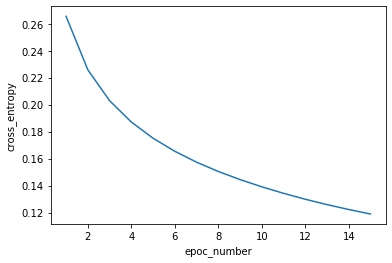

In [29]:
X_axis1 = range(1,16)
Y_axis1 = clf.c_entropy
plt.plot(X_axis, Y_axis)
plt.xlabel("epoc_number")
plt.ylabel("cross_entropy")

In [50]:
clf.c_entropy

array([0.26554005, 0.22591287, 0.203004  , 0.18717832, 0.17515861,
       0.16547947, 0.15740277, 0.15049621, 0.14448641, 0.13913782,
       0.1342917 , 0.12990422, 0.12592175, 0.12228273, 0.11893596])

In [28]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, clf.predict(X_test))

0.9591

## tanh関数,Xabierによる初期化、Adagrad、４層

In [40]:
class ScratchDeepNeuralNetrowkClassifier3:
    def __init__(self, verbose = True, iter_num=1, lr=0.002, sigma=0.02):
        self.verbose = verbose
        self.iter_num = iter_num
        self.lr = lr
        self.sigma = sigma

    def fit(self,X,y):

        self.n_features = X.shape[1]
        self.n_nodes1 = 400
        self.n_nodes2 = 200
        self.n_nodes3 = 60
        self.n_output = 10
        
        optimizer1 = AbaGrad(self.lr)
        optimizer2 = AbaGrad(self.lr)
        optimizer3 = AbaGrad(self.lr)
        optimizer4 = AbaGrad(self.lr)

        get_mini_batch = GetMiniBatch(X, y)

        self.FC1 = FC(self.n_features, self.n_nodes1, Xavier_Initializer(self.sigma), optimizer1)
        self.activation1 = Tanh()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, Xavier_Initializer(self.sigma), optimizer2)
        self.activation2 = Tanh()
        self.FC3 = FC(self.n_nodes2, self.n_nodes3, Xavier_Initializer(self.sigma), optimizer3)
        self.activation3 = Tanh()        
        self.FC4 = FC(self.n_nodes3, self.n_output, Xavier_Initializer(self.sigma), optimizer4)
        self.activation4 = Softmax()
        
        self.c_entropy = np.zeros(self.iter_num)

        for i in range(self.iter_num):
            for mini_X_train, mini_y_train in get_mini_batch:

                ### forward
                self.A1 = self.FC1.forward(mini_X_train)
                self.Z1 = self.activation1.forward(self.A1)
                self.A2 = self.FC2.forward(self.Z1)
                self.Z2 = self.activation2.forward(self.A2)
                self.A3 = self.FC3.forward(self.Z2)
                self.Z3 = self.activation3.forward(self.A3)
                self.A4 = self.FC4.forward(self.Z3)
                self.Z4 = self.activation4.forward(self.A4)

                ### backward　cross_entropy の表示
                self.delta1 = self.activation4.backward(mini_y_train)
                
#                 self.c_entropy = self.activation3.cross_entropy_error(self.A3,mini_y_train)
#                 print(self.c_entropy)
                
                self.dZ3 = self.FC4.backward(self.delta1)
                self.delta2 = self.activation3.backward(self.dZ3)
                self.dZ2 = self.FC3.backward(self.delta2)
                self.delta3 = self.activation2.backward(self.dZ2)
                self.dZ1 = self.FC2.backward(self.delta3)
                self.delta4 = self.activation1.backward(self.dZ1)
                self.dZ4 = self.FC1.backward(self.delta4)

                
                #print(c_entropy)
            
            EA1 = self.FC1.forward(X)
            EZ1 = self.activation1.forward(EA1)
            EA2 = self.FC2.forward(EZ1)
            EZ2 = self.activation2.forward(EA2)
            EA3 = self.FC3.forward(EZ2)
            EZ3 = self.activation3.forward(EA3)
            EA4 = self.FC4.forward(EZ3)
            self.EZ4 = self.activation4.forward(EA4)

            self.c_entropy[i] =  self.activation4.cross_entropy_error(self.EZ4, y)
                
    def predict(self, X):
        PA1 = self.FC1.forward(X)
        PZ1 = self.activation1.forward(PA1)
        PA2 = self.FC2.forward(PZ1)
        PZ2 = self.activation2.forward(PA2)
        PA3 = self.FC3.forward(PZ2)
        PZ3 = self.activation3.forward(PA3)
        PA4 = self.FC4.forward(PZ3)
        PZ4 = self.activation4.forward(PA4)
        
        pred = np.argmax(PZ4,axis=1)
        return pred


In [44]:
clf3 = ScratchDeepNeuralNetrowkClassifier3(True,15)
clf3.fit(X_train, y_train)

Text(0, 0.5, 'cross_entropy')

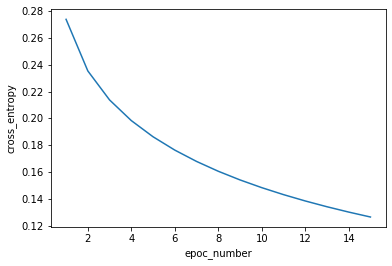

In [57]:
X_axis2 = range(1,16)
Y_axis2 = clf3.c_entropy
plt.plot(X_axis2, Y_axis2)
plt.xlabel("epoc_number")
plt.ylabel("cross_entropy")

In [48]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, clf3.predict(X_test))

0.9565

In [49]:
clf3.c_entropy

array([0.2738768 , 0.23539812, 0.21375039, 0.19833899, 0.18626754,
       0.17632289, 0.16787241, 0.16053798, 0.15407196, 0.14830175,
       0.14310154, 0.1383766 , 0.13405363, 0.13007469, 0.12639316])

## tanh関数,Xabierによる初期化、SGD、４層

In [51]:
class ScratchDeepNeuralNetrowkClassifier4:
    def __init__(self, verbose = True, iter_num=1, lr=0.002, sigma=0.02):
        self.verbose = verbose
        self.iter_num = iter_num
        self.lr = lr
        self.sigma = sigma

    def fit(self,X,y):

        self.n_features = X.shape[1]
        self.n_nodes1 = 400
        self.n_nodes2 = 200
        self.n_nodes3 = 60
        self.n_output = 10
        
        optimizer = SGD(self.lr)

        get_mini_batch = GetMiniBatch(X, y)

        self.FC1 = FC(self.n_features, self.n_nodes1, Xavier_Initializer(self.sigma), optimizer)
        self.activation1 = Tanh()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, Xavier_Initializer(self.sigma), optimizer)
        self.activation2 = Tanh()
        self.FC3 = FC(self.n_nodes2, self.n_nodes3, Xavier_Initializer(self.sigma), optimizer)
        self.activation3 = Tanh()        
        self.FC4 = FC(self.n_nodes3, self.n_output, Xavier_Initializer(self.sigma), optimizer)
        self.activation4 = Softmax()
        
        self.c_entropy = np.zeros(self.iter_num)

        for i in range(self.iter_num):
            for mini_X_train, mini_y_train in get_mini_batch:

                ### forward
                self.A1 = self.FC1.forward(mini_X_train)
                self.Z1 = self.activation1.forward(self.A1)
                self.A2 = self.FC2.forward(self.Z1)
                self.Z2 = self.activation2.forward(self.A2)
                self.A3 = self.FC3.forward(self.Z2)
                self.Z3 = self.activation3.forward(self.A3)
                self.A4 = self.FC4.forward(self.Z3)
                self.Z4 = self.activation4.forward(self.A4)

                ### backward　cross_entropy の表示
                self.delta1 = self.activation4.backward(mini_y_train)
                
#                 self.c_entropy = self.activation3.cross_entropy_error(self.A3,mini_y_train)
#                 print(self.c_entropy)
                
                self.dZ3 = self.FC4.backward(self.delta1)
                self.delta2 = self.activation3.backward(self.dZ3)
                self.dZ2 = self.FC3.backward(self.delta2)
                self.delta3 = self.activation2.backward(self.dZ2)
                self.dZ1 = self.FC2.backward(self.delta3)
                self.delta4 = self.activation1.backward(self.dZ1)
                self.dZ4 = self.FC1.backward(self.delta4)

                
                #print(c_entropy)
            
            EA1 = self.FC1.forward(X)
            EZ1 = self.activation1.forward(EA1)
            EA2 = self.FC2.forward(EZ1)
            EZ2 = self.activation2.forward(EA2)
            EA3 = self.FC3.forward(EZ2)
            EZ3 = self.activation3.forward(EA3)
            EA4 = self.FC4.forward(EZ3)
            self.EZ4 = self.activation4.forward(EA4)

            self.c_entropy[i] =  self.activation4.cross_entropy_error(self.EZ4, y)
                
    def predict(self, X):
        PA1 = self.FC1.forward(X)
        PZ1 = self.activation1.forward(PA1)
        PA2 = self.FC2.forward(PZ1)
        PZ2 = self.activation2.forward(PA2)
        PA3 = self.FC3.forward(PZ2)
        PZ3 = self.activation3.forward(PA3)
        PA4 = self.FC4.forward(PZ3)
        PZ4 = self.activation4.forward(PA4)
        
        pred = np.argmax(PZ4,axis=1)
        return pred


In [54]:
clf4 = ScratchDeepNeuralNetrowkClassifier4(True,15)
clf4.fit(X_train, y_train)

Text(0, 0.5, 'cross_entropy')

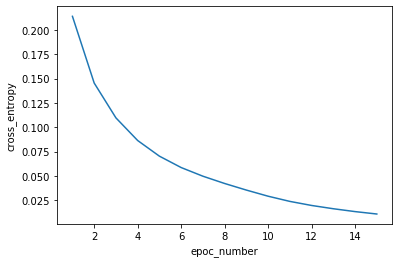

In [56]:
X_axis4 = range(1,16)
Y_axis4 = clf4.c_entropy
plt.plot(X_axis4, Y_axis4)
plt.xlabel("epoc_number")
plt.ylabel("cross_entropy")

In [55]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, clf4.predict(X_test))

0.9798